# Comparing actuals with benchmark, using pandas

In this exercise we will get, prepare and merge data from 3 different sources in order to make a visual comparison. We have the follwing data:
1. order data in an Excel file
2. customer data in a csv file
3. sales benchmark data in an html file

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%pwd

'C:\\Users\\Analyst\\surfdrive\\Sync\\17-18\\1\\Machine Learning\\Python\\Notebooks\\playground\\ActualsBenchmark'

First read the benchmarkdata from the html file. Pandas's read_html() facility depends on the html5lib package which in its turn depends on the beautifulsoup package.

read_html returns a list of pandas dataframes. One for each table it encounters on the html page.

In [3]:
import html5lib

df_bm = pd.read_html('dummytxt.html')[0]
df_bm.head()

,Plaats,Maand,18-24,25-39,40-58,59-69,70-100
0,Best,jan,68,76,76,122,108
1,Eindhoven,jan,93,60,60,72,137
2,Helmond,jan,70,99,68,70,124
3,Nuenen,jan,48,68,85,37,44
4,Veldhoven,jan,91,105,68,112,144


Modify the dataframe from wide to long format in order to be able to merge.

In [4]:
df_bm = df_bm.melt(id_vars=['Plaats', 'Maand'], var_name='Segment', value_name='Benchmark')

df_bm.head()

,Plaats,Maand,Segment,Benchmark
0,Best,jan,18-24,68
1,Eindhoven,jan,18-24,93
2,Helmond,jan,18-24,70
3,Nuenen,jan,18-24,48
4,Veldhoven,jan,18-24,91


Read order data from the Excel file.

In [5]:
df_ord = pd.read_excel('opdracht.xlsx', sheetname='sales')
df_ord.head(3)

,nr,datum,bedrag
0,1009,2017-01-03,106
1,1012,2017-01-03,55
2,1006,2017-01-09,37


Verify the the datum column is in the proper date format.

In [6]:
df_ord.dtypes

nr                 int64
datum     datetime64[ns]
bedrag             int64
dtype: object

Read customer data from the csv file. Skip the rows containing comment.

In [7]:
df_cust = pd.read_csv('Klanten.csv', skiprows=8)
df_cust.head(3)

,nr,naam,gesl,gebdat,wpl,vooropl,tel
0,1004,tinus,m,26-01-1983,nue,VO,06-52477478
1,1005,henk,m,04-12-1961,nue,HBO,06-49945368
2,1006,lars,m,06-07-1967,ehv,VO,06-42766537


Expand the abbreviated city name to its full name so we can merge with customer data.

In [8]:
df_wpl = pd.DataFrame(data={'wpl': 'ehv hmd nue vhv'.split(), 'woonplaats': 'Eindhoven Helmond Nuenen Veldhoven'.split()})

df_cust = df_cust.merge(df_wpl, on='wpl')

df_cust.head(3)

,nr,naam,gesl,gebdat,wpl,vooropl,tel,woonplaats
0,1004,tinus,m,26-01-1983,nue,VO,06-52477478,Nuenen
1,1005,henk,m,04-12-1961,nue,HBO,06-49945368,Nuenen
2,1019,klara,v,26-07-1962,nue,MBO,06-26209998,Nuenen


Verify the the datum column is in the proper date format.

In [9]:
df_cust['gebdat'].dtypes

dtype('O')

Date as string. That's no good: change to pandas datetime type.

In [10]:
df_cust['gebdat'] = pd.to_datetime(df_cust['gebdat'])
print(df_cust['gebdat'].dtypes)

df_cust.head(3)

datetime64[ns]


,nr,naam,gesl,gebdat,wpl,vooropl,tel,woonplaats
0,1004,tinus,m,1983-01-26,nue,VO,06-52477478,Nuenen
1,1005,henk,m,1961-04-12,nue,HBO,06-49945368,Nuenen
2,1019,klara,v,1962-07-26,nue,MBO,06-26209998,Nuenen


Calculate age from date of birth (gebdat).

In [11]:
df_cust['leeftijd'] = (pd.to_datetime('today') - df_cust['gebdat']).astype('timedelta64[Y]')

df_cust.head(3)

,nr,naam,gesl,gebdat,wpl,vooropl,tel,woonplaats,leeftijd
0,1004,tinus,m,1983-01-26,nue,VO,06-52477478,Nuenen,34.0
1,1005,henk,m,1961-04-12,nue,HBO,06-49945368,Nuenen,56.0
2,1019,klara,v,1962-07-26,nue,MBO,06-26209998,Nuenen,55.0


Map age to the proper age segment so as to be able to merge with benchmark data.

In [12]:
def age_to_segment(n):
    return ('18-24' if n < 25 else
            '25-39' if n < 40 else
            '40-58' if n < 59 else
            '59-69' if n < 70 else
            '70-100')
        
df_cust['segment'] = df_cust['leeftijd'].apply(age_to_segment)

df_cust.head(3)

,nr,naam,gesl,gebdat,wpl,vooropl,tel,woonplaats,leeftijd,segment
0,1004,tinus,m,1983-01-26,nue,VO,06-52477478,Nuenen,34.0,25-39
1,1005,henk,m,1961-04-12,nue,HBO,06-49945368,Nuenen,56.0,40-58
2,1019,klara,v,1962-07-26,nue,MBO,06-26209998,Nuenen,55.0,40-58


Expand (merge) order data with customer data.

In [13]:
df_ord_ext = df_ord.merge(df_cust[['nr', 'woonplaats', 'segment']], on='nr')

df_ord_ext.head(3)

,nr,datum,bedrag,woonplaats,segment
0,1009,2017-01-03,106,Veldhoven,40-58
1,1009,2017-02-17,254,Veldhoven,40-58
2,1009,2017-03-02,138,Veldhoven,40-58


Group sales volume of orders by month, city and age segment.

In [14]:
df_ord_ext = df_ord_ext.groupby([df_ord_ext['datum'].dt.month, 'woonplaats', 'segment'])['bedrag'].sum().reset_index()
print(df_ord_ext.columns)

df_ord_ext.rename(columns={'datum': 'maandnr'}, inplace=True)

df_ord_ext.head()

Index(['datum', 'woonplaats', 'segment', 'bedrag'], dtype='object')


,maandnr,woonplaats,segment,bedrag
0,1,Eindhoven,40-58,313
1,1,Eindhoven,59-69,110
2,1,Helmond,40-58,260
3,1,Nuenen,25-39,200
4,1,Nuenen,40-58,235


In order to map month numbers to (Dutch) month abbeviations, we first introduce a lookup table.

In [15]:
lut_month = pd.Series(['', 'jan', 'feb', 'mrt'])

lut_month

0       
1    jan
2    feb
3    mrt
dtype: object

Now map month numbers to abbreviatted names.

In [16]:
df_ord_ext = df_ord_ext.merge(lut_month.to_frame(name='maand'), left_on='maandnr', right_index=True)

df_ord_ext.head()

,maandnr,woonplaats,segment,bedrag,maand
0,1,Eindhoven,40-58,313,jan
1,1,Eindhoven,59-69,110,jan
2,1,Helmond,40-58,260,jan
3,1,Nuenen,25-39,200,jan
4,1,Nuenen,40-58,235,jan


Now merge benchmark sales figures with actual sales figures. We want to maintain all benchmark rows for which we have no actual sales.

In [17]:
df_actuals_vs_bm = df_bm.merge(
    df_ord_ext, left_on=['Plaats', 'Segment', 'Maand'],
    right_on=['woonplaats', 'segment', 'maand'],
    how='left')[['Plaats', 'Maand', 'Segment', 'Benchmark', 'bedrag']]

df_actuals_vs_bm[df_actuals_vs_bm['bedrag'] > 0]

,Plaats,Maand,Segment,Benchmark,bedrag
27,Nuenen,jan,25-39,68,200.0
28,Veldhoven,jan,25-39,105,285.0
34,Veldhoven,feb,25-39,123,199.0
37,Eindhoven,mrt,25-39,92,12.0
40,Veldhoven,mrt,25-39,96,369.0
49,Eindhoven,jan,40-58,60,313.0
50,Helmond,jan,40-58,68,260.0
51,Nuenen,jan,40-58,85,235.0
52,Veldhoven,jan,40-58,68,106.0
56,Helmond,feb,40-58,109,279.0


We can drill into a specific city/segment combination and visualize actuals vs benchmark. If we set a proper index, we can city and segement names to index the slice from the dataframe that we want to visualize.

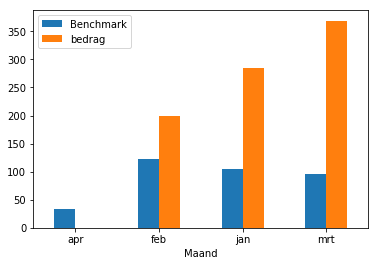

In [31]:
(df_actuals_vs_bm.set_index(['Plaats', 'Segment', 'Maand'])
 .sort_index()
 .loc[('Veldhoven', '25-39')]
 .plot.bar(rot=0));

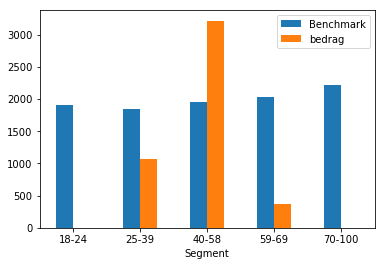

In [40]:
df_actuals_vs_bm.pivot_table(index=['Segment'], aggfunc='sum').plot.bar(rot=0);

You can make various drill downs on the dataframe and visualize different slices and pivot tables of the frame. However, multi-index slicing is not very straightforward in pandas and surely not suitable for an end user doing casual exploratory analysis. For that purpose, Excel is unbeatable.
In order to use Excel's pivoting capabilities, we need to export the dataframe to an Excel table and then create a pivot table in Excel. We can't directly export a dataframe to an Excel pivot table as the Excel pivot table has a specific storage layout. (We could use something like XLWings, though, but XLWings uses the Excel API to eventually create an Excel pivot table.

Let's export to a fresh Excel workbook.

In [42]:
df_actuals_vs_bm.to_excel(pd.ExcelWriter('pandas.xlsx'),'data')

Note that the Excel file will be overwritten each time `DataFrame.to_excel()` is ececuted. Therefore it is best to host the Excel pivot table in a new file (e.g. pandasPT.xlsx) that maintains a Power Query (Get Data) connection to the Excel file created by pandas.

Finally, in order to prepare for a seaborn faceted plot, we have to bring our dataframe to long format.

In [22]:
df_long = df_actuals_vs_bm.melt(id_vars=['Plaats', 'Segment', 'Maand'], var_name='Type')

df_long.head()

,Plaats,Segment,Maand,Type,value
0,Best,18-24,jan,Benchmark,68.0
1,Eindhoven,18-24,jan,Benchmark,93.0
2,Helmond,18-24,jan,Benchmark,70.0
3,Nuenen,18-24,jan,Benchmark,48.0
4,Veldhoven,18-24,jan,Benchmark,91.0


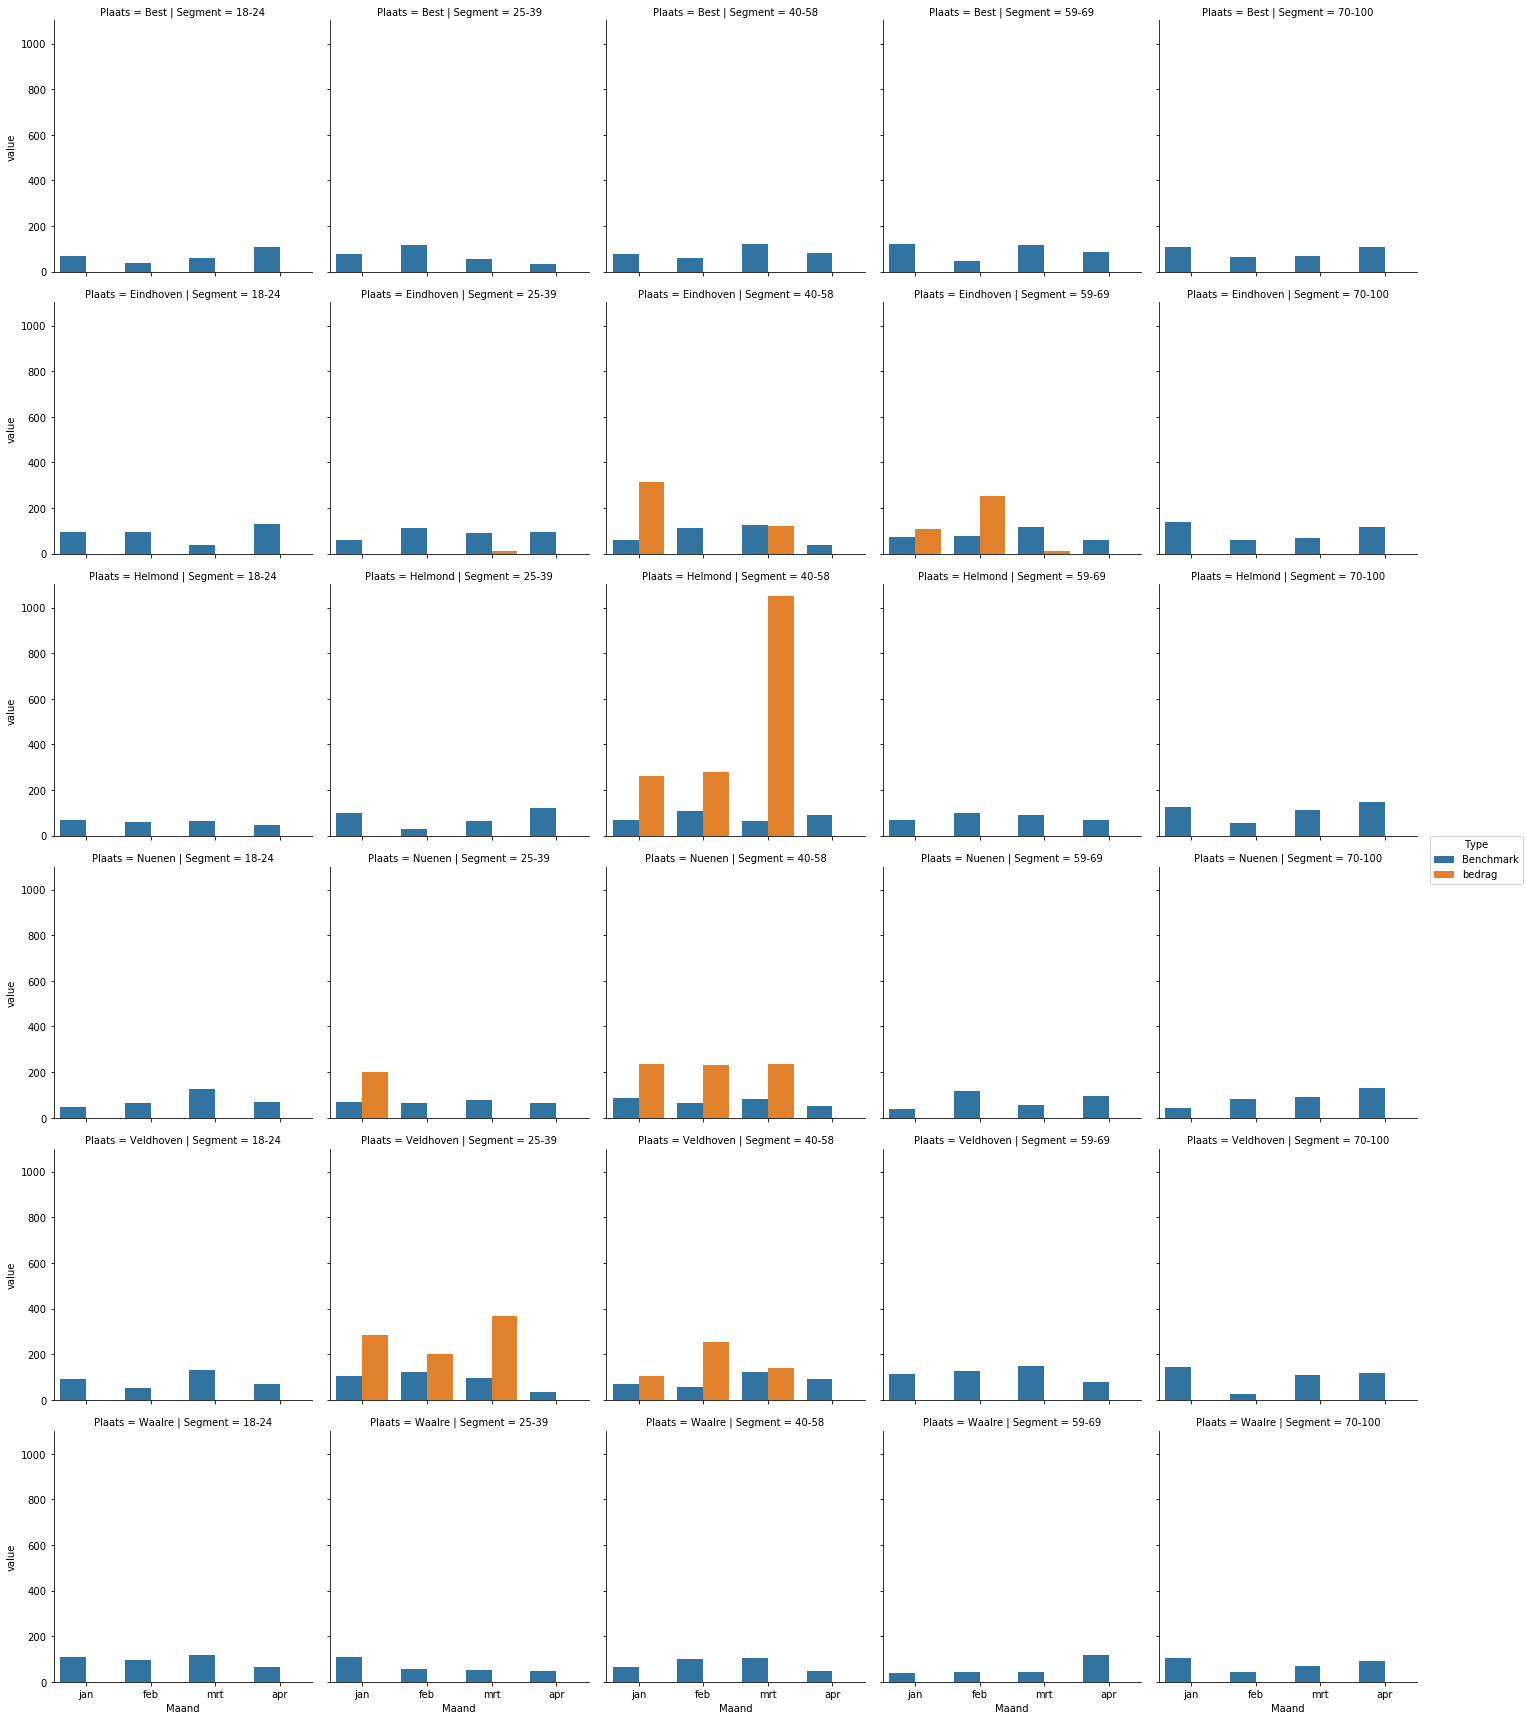

In [20]:
import seaborn as sns

sns.factorplot(data=df_long, x='Maand', y='value', hue='Type', row='Plaats', col='Segment', kind='bar');